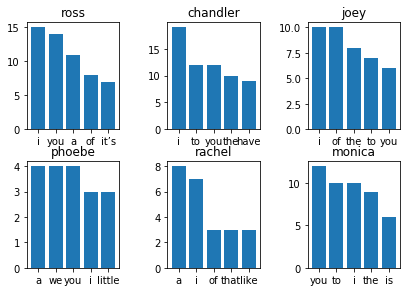

In [2]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


class CleanData:
    """
    This class is used to clean data
    """

    def extractDialogue(self):
        """
        A function that extract dialogue lines from the original script file and remove all other meta-data
        Returns:
            1.list: A list of clean-up character names and dilogues
        """
        input_file = open("input_script.txt", 'r', encoding='utf-8')

        input_data = input_file.read()

        delete_bracket = re.sub(r"\(.*?\)|\[.*?\]", "", input_data)  # Delete all sentences that contain(),[]

        delete_space = re.sub(r'[^\S\r\n]{2,}', " ", delete_bracket)  # Remove the spaces after the parenthesis

        delete_by = re.sub(r".*by:.*", "", delete_space)  # Delete the sentence with the beginning: by

        delete_empty_rows = "".join([s for s in delete_by.splitlines(True) if s.strip()])  # Delete all empty rows

        separate_input = delete_empty_rows.split('\n')  # Separate them in the form of line breaks

        for line in separate_input:
            if re.search(r"^((?!:).)*$", line) != None:  # Delete all sentences without colon
                separate_input.remove(line)

        clean_dialogue = []
        for i in range(len(separate_input)):  # Separate lists into character names, and their dialogues.
            clean_line = separate_input[i].split(": ")  # Delete the space after the colon
            clean_dialogue.append(tuple(clean_line))  # covert list to tuple

        input_file.close()
        return clean_dialogue

    def saveExtractDialogue(self):
        """
        A function that put the extracted text in a new file
        """
        extract_dialogue = self.extractDialogue()

        with open('32009682_clean_dialogue.txt', 'w', encoding='utf-8') as f:
            f.write(str(extract_dialogue))

    def separateDialogue(self):
        """
        A function that separate the dialogues of different characters(roles)
         Return:
            1.dictionary: A dictionary to tore dialogue together according to the role
        """
        clean_dialogue_file = open('32009682_clean_dialogue.txt', 'r', encoding='utf-8')

        clean_dialogue_data = clean_dialogue_file.read()

        clean_dialogue_list = eval(clean_dialogue_data)  # Converts the String read out by the file to the List

        separate_dialogue = {}  # Bring together dialogue under one character

        for line in clean_dialogue_list:
            if line[0] in separate_dialogue.keys():
                separate_dialogue[line[0]] += (line[1] + '\n')
            else:
                separate_dialogue[line[0]] = (line[1] + '\n')

        # Write the dialogues of the corresponding role to its file
        for role in separate_dialogue:
            with open('32009682_' + role.lower() + '.txt', 'w', encoding='utf-8') as f:
                f.write(str(separate_dialogue[role]))

        clean_dialogue_file.close()
        return separate_dialogue


class AnalyzeData:
    """
    This class is used to analyze data
    """

    def obtainFrequentWords(self):
        """
        A function that obtain Top 5 Frequent Words For Each Role
        Return:
            1.dataframe: A dataframe to store the information of role,word,and freq:
        """

        clean_data = CleanData()
        clean_data.saveExtractDialogue()  # Call the method of the CleanData class
        separate_dialogue = clean_data.separateDialogue()

        holding = {}  # Because dataframe needs to be merged at the end, all holding data frames are stored using holding{}

        for role in separate_dialogue:
            separate_file = open('32009682_' + role.lower() + '.txt', 'r', encoding='utf-8')

            separate_data = separate_file.read()

            delete_line_break = separate_data.replace("\n", "")  # Remove the line break

            separate_word = delete_line_break.split(' ')  # Separate words according to space

            unique_word = set(separate_word)  # Find words that don't repeat in a role

            if len(unique_word) > 100:  # Select a character with a number of unique words greater than 100

                lower_data = separate_data.lower()  # Case insensitive, so all data is replaced with lowercase

                separate_lower_data = lower_data.split("\n")

                separate_word = []  # The row frequency is obtained when each row is calculated together to remove the duplicate elements

                for i in separate_lower_data[:-1]:  # Because the last line is \n , so don't read it specifically

                    list_dialogue = i.strip().split(" ")  # Delete the spaces at the end of each line

                    new_set = set(list_dialogue)  # Remove the duplicate elements from each row
                    separate_word += new_set

                word_counter = Counter(separate_word)  # Calculate the number of words that appear for each word

                highest_frequencies = word_counter.most_common(5)  # The top 5 with the highest frequency

                df = pd.DataFrame(highest_frequencies, columns=['word', 'freq'])  # Store the data to dataframe

                df.insert(0, 'role', role.lower())  # Insert this column of the role into the first column

                holding[role] = df  # Store all hold data frames

            separate_file.close()

        df_data = pd.concat(list(holding.values()), ignore_index=True)  # merged dataframe

        df_data.to_csv('32009682_data.csv', encoding='utf-8', index=None)  # Save to csv file, but do not index

        return df_data

    def visualiseData(self):
        """
        Visualise the DataFrame with a graph.
        """
        analze_data = AnalyzeData()
        df_data = analze_data.obtainFrequentWords()

        np_data = np.array(df_data)
        np_data = np_data.tolist()  # covert np array to list
        role = []  # This list indicates which role the picture belongs to
        role_x = []  # This list represents the word that appears on the x-axis of the picture
        role_y = []  # This list represents freq (the frequency of lines in which words appear) that appear on the y axis of the picture
        for i in np_data:
            role.append(i[0])
            role_x.append(i[1])
            role_y.append(i[2])

        separate_role = []
        for j in range(len(role)):
            if j % 5 == 0:  # Remove duplicate characters
                separate_role.append(role[j])

        n = 5  # 5 for a small group
        separate_role_x = [role_x[i:i + n] for i in range(0, len(role_x), n)]
        separate_role_y = [role_y[i:i + n] for i in range(0, len(role_y), n)]

        graph_num = int(len(role) / 5)

        fig, ax_arr = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False)  # draw subplots

        ax_arr = ax_arr.flatten()

        fig.tight_layout()

        # Draw subplots, a picture of a character
        for i in range(graph_num):
            ax_arr[i].bar(separate_role_x[i], separate_role_y[i])
            ax_arr[i].set_title(separate_role[i])

        plt.show()


# Create an instance of AnalyzeData class and call the visualiseData method of that instance, and then the program will run automatically
analze_data = AnalyzeData()
analze_data.visualiseData()

In [ ]:
"""
Provide concise and precise observations on Task4:
    Each picture represents a character's data, the horizontal axis is the highest frequency of 5 words, 
vertical axis is the corresponding frequency of these words. 
    The bar chart is selected to clearly show a role, show the comparison between the words, 
each bar is a clear and intuitive representation of the data
    From the resulting graph, it can be seen that "i" appears the highest frequency, and the frequency of"you, the, a" appears second only to "i", 
it seems that people still like to speak in first and second person, and the article also uses a lot

"""  